In [26]:
import torch
from dataset import DATASET_FILE
from datasets import load_dataset
import utils
from model import DocTower, QueryTower
from tokenizer import Word2VecTokenizer
import matplotlib.pyplot as plt
import numpy as np

In [27]:
datasets = torch.load(DATASET_FILE, weights_only=False)
train_dataset = datasets["train"]
validation_dataset = datasets["validation"]
test_dataset = datasets["test"]

In [21]:
import redis

r = redis.Redis(host="localhost", port=6379, db=0)
raw = r.hget("doc:train_57095_6", "embedding")
vec = np.frombuffer(raw, dtype=np.float32)
print("Doc embedding norm:", np.linalg.norm(vec))

Doc embedding norm: 1.0


In [8]:
ms_marco_data = load_dataset("ms_marco", "v1.1")

Train: mean=70.9,  std=25.7,  min=3,  p50=71,  p95=112,  max=231
Val  : mean=70.9,  std=25.7,  min=4,  p50=71,  p95=112,  max=195
Test : mean=70.8,  std=25.6,  min=4,  p50=71,  p95=112,  max=211


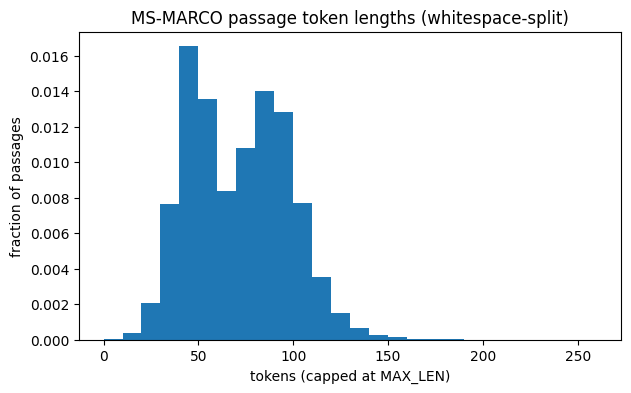

In [6]:
# %%
MAX_LEN = 256            # same value you use in the tokenizer

# Load once (cached after first call)
ms_marco = load_dataset("ms_marco", "v1.1")

def passage_lengths(split="train"):
    """Return list of token counts (whitespace-split) for every passage in a split."""
    lens = []
    for row in ms_marco[split]:
        lens.extend(len(p.lower().split()[:MAX_LEN])
                     for p in row["passages"]["passage_text"])
    return lens

train_lens = passage_lengths("train")
val_lens   = passage_lengths("validation")
test_lens  = passage_lengths("test")

def summarise(name, arr):
    arr = np.asarray(arr)
    print(f"{name}: mean={arr.mean():.1f},  std={arr.std():.1f},  "
          f"min={arr.min()},  p50={np.percentile(arr,50):.0f},  p95={np.percentile(arr,95):.0f},  max={arr.max()}")

summarise("Train", train_lens)
summarise("Val  ", val_lens)
summarise("Test ", test_lens)

# ---- histogram (all splits together) ----
all_lens = np.concatenate([train_lens, val_lens, test_lens])
plt.figure(figsize=(7,4))
plt.hist(all_lens, bins=range(0, MAX_LEN+10, 10), density=True)
plt.title("MS-MARCO passage token lengths (whitespace-split)")
plt.xlabel("tokens (capped at MAX_LEN)")
plt.ylabel("fraction of passages")
plt.show()

In [28]:
device = utils.get_device()
tokenizer = Word2VecTokenizer()
checkpoint = torch.load(utils.MODEL_FILE, map_location=device)

query_tower = QueryTower(
    tokenizer.embeddings,
    embed_dim=checkpoint["embed_dim"],
    dropout_rate=checkpoint["dropout_rate"],
    ).to(device)
query_tower.load_state_dict(checkpoint["query_tower"])
doc_tower = DocTower(
    tokenizer.embeddings,
    embed_dim=checkpoint["embed_dim"],
    dropout_rate=checkpoint["dropout_rate"],
    ).to(device)
doc_tower.load_state_dict(checkpoint["doc_tower"])


<All keys matched successfully>

In [30]:
# --- Build embeddings for TSNE visualisation ---
sample_size = 100  # adjust as needed
sample_triplets = train_dataset[:sample_size]

vecs = []
labels = []
query_tower.eval()
doc_tower.eval()
with torch.no_grad():
    for trip in sample_triplets:
        q_emb = query_tower(trip["query"].unsqueeze(0).to(device)).cpu().numpy()[0]
        pos_emb = doc_tower(trip["positive"].unsqueeze(0).to(device)).cpu().numpy()[0]
        neg_emb = doc_tower(trip["negative"].unsqueeze(0).to(device)).cpu().numpy()[0]

        vecs.append(q_emb);  labels.append("query")
        vecs.append(pos_emb); labels.append("pos")
        vecs.append(neg_emb); labels.append("neg")

vecs = np.array(vecs)
print("Prepared", len(vecs), "embeddings for TSNE")

Prepared 300 embeddings for TSNE


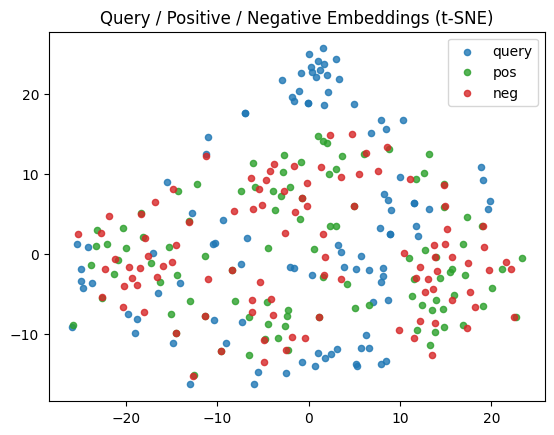

In [31]:
from sklearn.manifold import TSNE

# assume vecs is (N, D) numpy array of query or doc embeddings
# labels is a list like ["query", "doc", "query", ...]

vecs_2d = TSNE(n_components=2, perplexity=30).fit_transform(vecs)

colour_map = {"query": "tab:blue",
              "pos": "tab:green",
              "neg": "tab:red"}

for label, colour in colour_map.items():
    idx = [i for i, lab in enumerate(labels) if lab == label]
    if idx:                                   # skip if none
        plt.scatter(vecs_2d[idx, 0],
                    vecs_2d[idx, 1],
                    c=colour, label=label,
                    s=20, alpha=0.8)

plt.title("Query / Positive / Negative Embeddings (t-SNE)")
plt.legend()
plt.show()

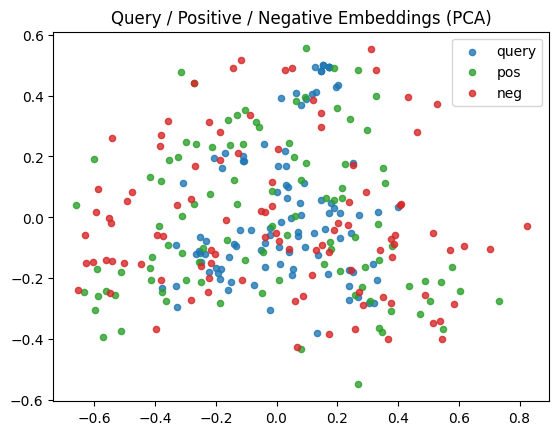

In [32]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2, random_state=0).fit_transform(vecs)

colour_map = {"query": "tab:blue",
              "pos": "tab:green",
              "neg": "tab:red"}

for label, colour in colour_map.items():
    idx = [i for i, lab in enumerate(labels) if lab == label]
    if idx:
        plt.scatter(pca_2d[idx, 0], pca_2d[idx, 1],
                    c=colour, label=label, s=20, alpha=0.8)

plt.title("Query / Positive / Negative Embeddings (PCA)")
plt.legend()
plt.show()